In [1]:
from braingeneers import analysis
import braingeneers.data.datasets_electrophysiology as ephys
import braingeneers.utils.smart_open_braingeneers as smart_open
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from braingeneers.analysis import plot
from braingeneers.analysis import single_unit

In [2]:
curated_path = [
                "~/disk/Opto/20221102_ucsf/hc11.1_plated-11.1_chip-16753_rec_11.2.22AM-immediate_phy/"\
                    "hc11.1_plated-11.1_chip-16753_rec_11.2.22AM-immediate_curated_neg.zip",
                "~/disk/Opto/20230402_ucsf/2023_04_02_hc328_spt/2023_04_02_hc328_0_curated.zip",
                "~/disk/Opto/20230402_ucsf/2023_04_02_hc328_spt/2023_04_02_hc328_7_curated.zip"
                ]
rec_path = [
            "~/disk/Opto/20221102_ucsf/hc11.1_plated-11.1_chip-16753_rec_11.2.22AM-immediate.raw.h5",
            "~/disk/Opto/20230402_ucsf/2023_04_02_hc328_spt/2023_04_02_hc328_0.raw.h5",
            "~/disk/Opto/20230402_ucsf/2023_04_02_hc328_spt/2023_04_02_hc328_7.raw.h5"
            ]
fig_name = [
            "fig1_actue_hc11.1_plated-11.1_chip-16753_rec_11.2.22AM-immediate",
            "fig1_post_culture_2023_04_02_hc328_0",
            "fig1_post_culture_2023_04_02_hc328_7"
            ]
figure_path = "figure1/"

In [3]:
i = 2
path = curated_path[i]
rec = rec_path[i]
name = fig_name[i]

spike_data = analysis.read_phy_files(path)
neuron_dict = spike_data.neuron_data[0]
config = spike_data.metadata[0]

fs = 20000.0
rec_period = [0, 70]

In [4]:
print(np.array(list(config.values())))

[[ 770.  1505. ]
 [1295.  1085. ]
 [1050.   962.5]
 ...
 [1715.   700. ]
 [ 735.  1837.5]
 [1400.  1627.5]]


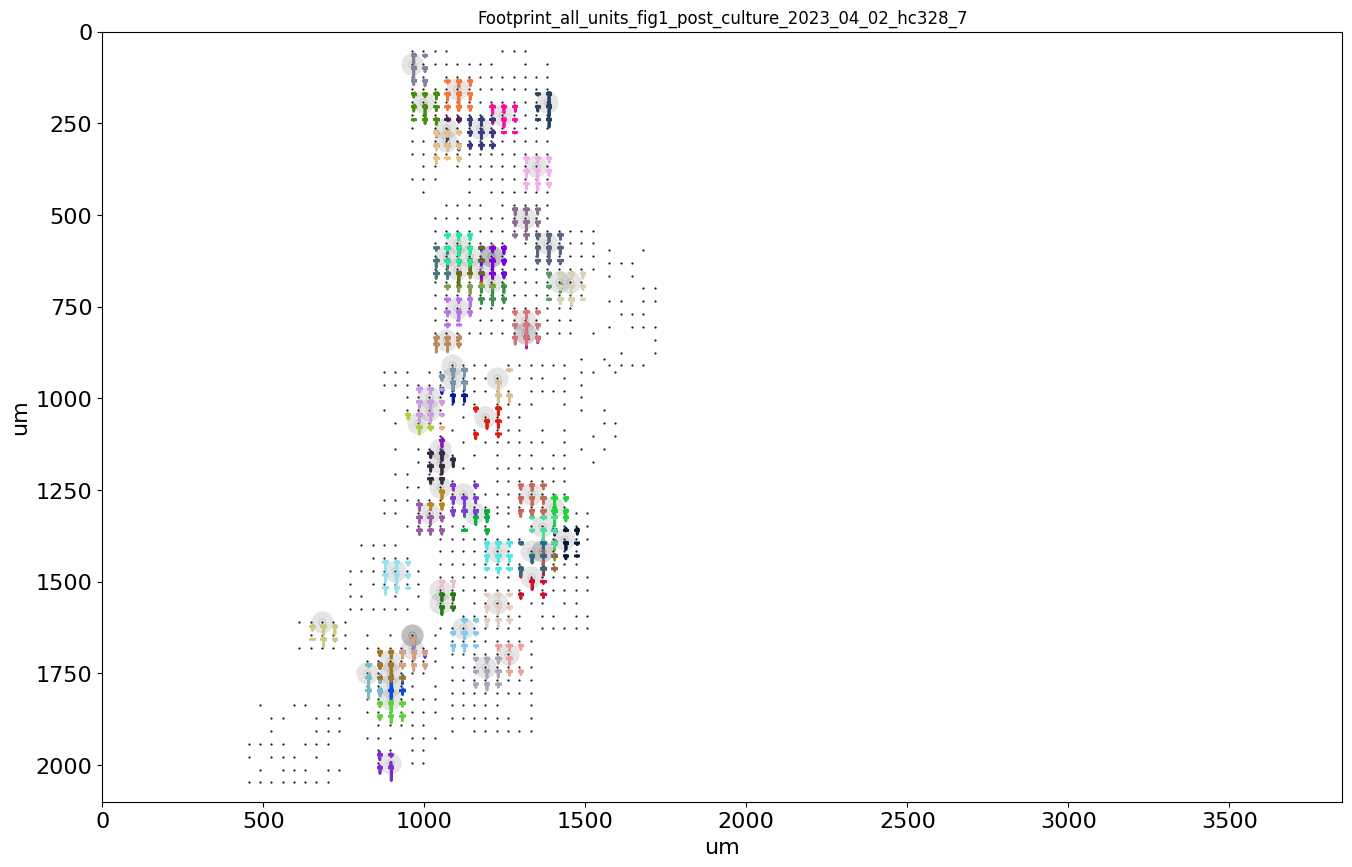

In [5]:
fig, axs = plt.subplots(figsize=(16, 10), facecolor='white')
axs = plot.plot_footprint_all(axs, name, neuron_dict, config)
axs.scatter(np.array(list(config.values()))[:, 0], np.array(list(config.values()))[:, 1], s=0.3, color='k')
axs.set_ylim(0, 2100)
axs.set_xlim(0, 3850)
axs.set_ylabel("um", fontsize=16)
axs.set_xlabel("um", fontsize=16)
axs.yaxis.set_tick_params(labelsize=16)
axs.xaxis.set_tick_params(labelsize=16)
axs.invert_yaxis()
# plt.show()
# fig.savefig(figure_path + '{}_footprint_overall.png'.format(name), transparent=True, dpi=300)
# fig.savefig(figure_path + '{}_footprint_overall.svg'.format(name), transparent=True, dpi=300)

#### Zoom in Spot
y = [480, 1100], x = [2200, 2800] for acute 

y = [270, 800], x = [900, 1800] for post culture (0)

y = [1200, 1750], x = [600, 1500] for post culture (6) (7)

In [6]:
# plot averaged waveform

# box_y = [480, 1100]
# box_x = [2200, 2800]
# ---------------------
# box_y = [270, 800]
# box_x = [900, 1800]
#----------------------
box_y = [1200, 1750]
box_x = [700, 1500]
su = single_unit.SingleUnit(neuron_dict, config)

In [7]:
box_units = {}
best_units = {}
for c in neuron_dict.keys():
    ch, position, temp_chs, temp_pos, templates = su.get_data_dict(c)
    if box_x[0] <= position[0] <= box_x[1] and box_y[0] <= position[1] <= box_y[1]:
        near_channels, near_positions = su.select_neighbor_channels(position, temp_chs, temp_pos)
        raw_traces = single_unit.load_raw_maxwell(rec, near_channels, rec_period)  # filtered, unconverted raw data
        raw_traces = analysis.butter_bandpass_filter(raw_traces, 300, 6000)
        if np.diff(np.searchsorted(spike_data.train[c]/1000, rec_period))[0] > 0: 
            cluster_spike_times = [spike_data.train[c]/1000 for _ in range(len(near_channels))]
            raw_spikes = single_unit.load_spikes_maxwell(rec, near_channels, cluster_spike_times, 
                                                         rec_period=rec_period, win=3)
            best_units[c] = {"channel": ch, "position": position,
                            "raw_spikes": raw_spikes[ch]}
            raw_waveforms = su.get_waveforms(raw_spikes)
            box_units[c] = {"id": c, "channel": ch, "position": position, 
                            "near_channels": near_channels, 
                            "near_positions": near_positions,
                            "waveforms": raw_waveforms}

In [8]:
import pickle
with open("figure1_footprints_post_box_units_0402_7.pkl", "wb") as file:
    pickle.dump(box_units, file)

In [9]:
import random
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
colors = get_colors(max(list(box_units.keys()))+1)

In [10]:
def plot_footprint_region(axs, filename, box_units):
    # axs.set_title("Footprint_box_units_{}".format(filename))
    ylim_min, ylim_max = float('inf'), -float('inf')
    y_margin = 0
    for k in box_units.keys():
        ch = box_units[k]['channel']
        waveforms = box_units[k]['waveforms']
        ylim_min = min(ylim_min, min(waveforms[ch]['mean']-waveforms[ch]['std']))
        ylim_max = max(ylim_max, max(waveforms[ch]['mean']+waveforms[ch]['std']))

    min_x, max_x, min_y, max_y = 4000, 0, 3000, 0
    for k in box_units.keys():
        temp_unit = box_units[k]
        ch = temp_unit['channel']
        pos = temp_unit['position']
        temp_chs = temp_unit['near_channels']
        temp_pos = temp_unit['near_positions']
        waveforms = temp_unit['waveforms']
        # axs.scatter(pos[0], pos[1], linewidth=10, alpha=0.2, color='grey')
        # axs.text(pos[0], pos[1], str(str(k)+", "+str(ch)), color="g", fontsize=12)
        # print(temp_chs, temp_pos, waveforms)
        
        for i in range(len(temp_chs)):
            temp_ch = temp_chs[i]
            chn_pos = temp_pos[i]
            c = '#ED2290' if temp_ch == ch else '#ED2290'
            da = 1 if chn_pos == pos else 17.5/(abs(chn_pos[0]-pos[0]) + abs(chn_pos[1]-pos[1]))

            min_x, max_x, min_y, max_y = \
                min(min_x, chn_pos[0]), max(max_x, chn_pos[0]), \
                min(min_y, chn_pos[1]), max(max_y, chn_pos[1])
            mean_waveform = waveforms[temp_ch]['mean']
            std = waveforms[temp_ch]['std']
            xx = waveforms[temp_ch]['time']
            axin = axs.inset_axes([chn_pos[0]-5, chn_pos[1]-5, 30, 80], transform=axs.transData)
            axin.plot(xx, mean_waveform, color=c, linewidth=1, label=str(k), alpha=da)
            # axin.plot(xx, mean_waveform-std, color=c, linewidth=0.5, alpha=0.3)
            # axin.plot(xx, mean_waveform+std, color=c, linewidth=0.5, alpha=0.3)
            # axin.fill_between(xx, mean_waveform - std, mean_waveform + std, color=c, alpha=0.3*da)
            axin.set_ylim([ylim_min - y_margin, ylim_max + y_margin])
            # axin.set_axis_off()
    axs.set_xlim(min_x-2*17.5, max_x+2*17.5)
    axs.set_ylim(min_y-2*17.5, max_y+2*17.5)
    axs.invert_yaxis()
    axs.axis('off') 
    return axs

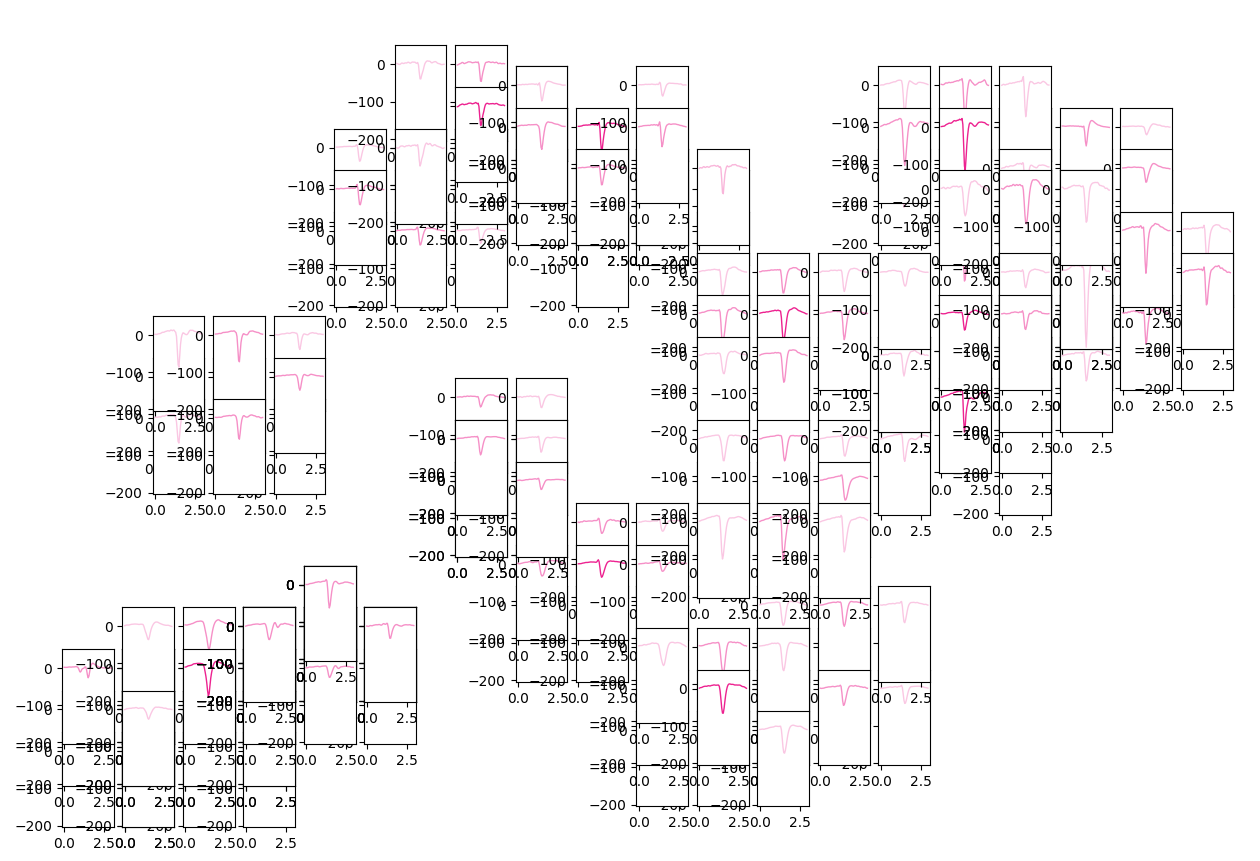

In [11]:
fig, axs = plt.subplots(figsize=(16, 10), facecolor='white')
axs = plot_footprint_region(axs, name, box_units)
# fig.savefig(figure_path + '{}_footprint_box_trans.png'.format(name), transparent=True, dpi=300)
# fig.savefig(figure_path + 'fig1_post_culture_hotpink_trans_3ms_scale.svg'.format(name), transparent=True, dpi=300)
# fig.savefig(figure_path + 'fig1_post_culture_hotpink_3ms.png'.format(name), dpi=300)
# fig.savefig(figure_path + '{}_footprint_box.svg'.format(name), dpi=300)


#### A list of waveforms and their firing rate

In [12]:
def get_ylim(box_units, y_margin=0):
    ylim_min, ylim_max = float('inf'), -float('inf')
    for k in box_units.keys():
        ch = box_units[k]['channel']
        waveforms = box_units[k]['waveforms']
        ylim_min = min(ylim_min, min(waveforms[ch]['mean']-waveforms[ch]['std']))
        ylim_max = max(ylim_max, max(waveforms[ch]['mean']+waveforms[ch]['std']))
    return ylim_min-y_margin, ylim_max+y_margin

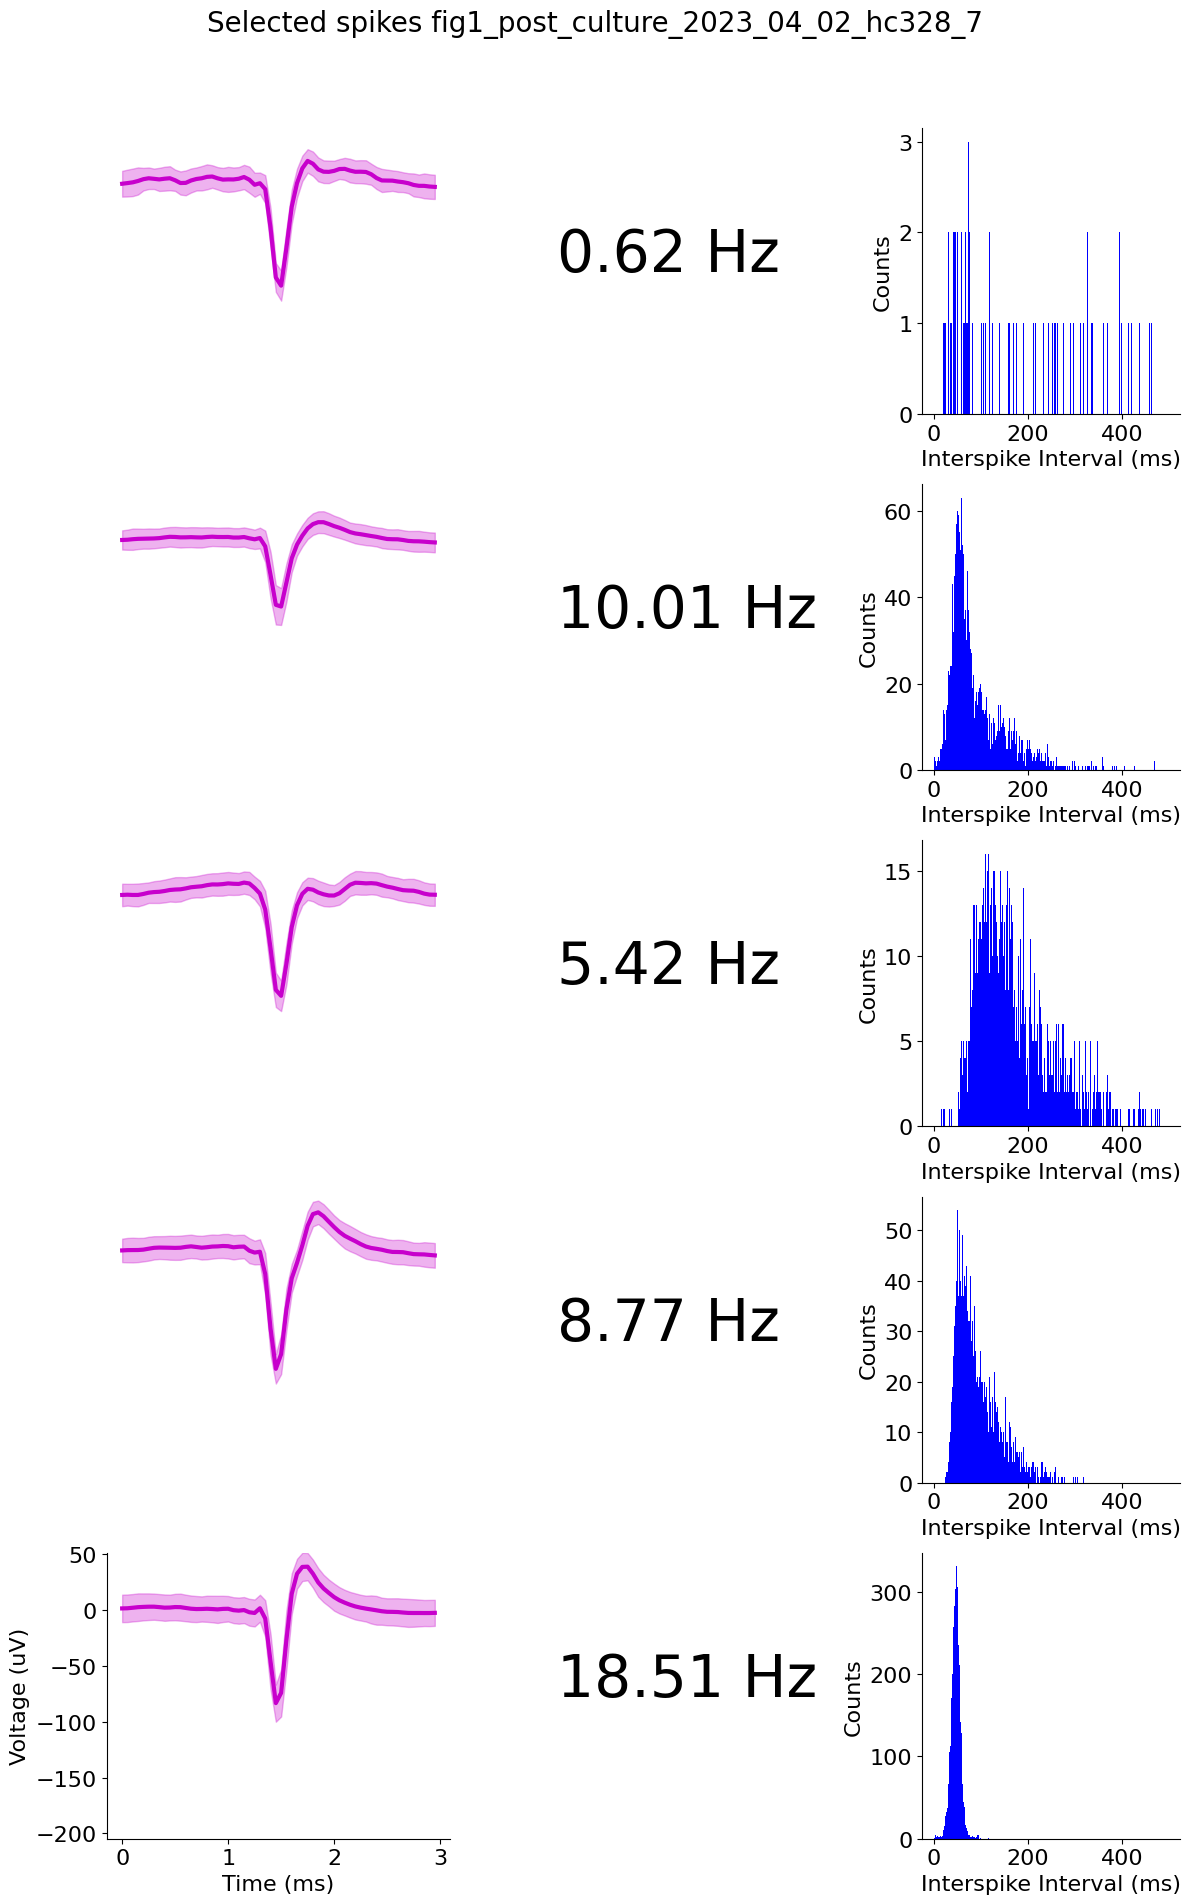

In [13]:

import random
selected_units = [0, 3, 6, 12, 24]
# rows = len(box_units)
rows = len(selected_units)
# get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(rows)]
# colors = get_colors(max(list(box_units.keys()))+1)
color="#C700CC"
fig, axs = plt.subplots(rows, 3, figsize=(3*4, rows*4), width_ratios=[4, 3, 3])
fig.suptitle("Selected spikes "+name, fontsize=20)
# fig.subplots_adjust(top=0.88)
ylim = (get_ylim(box_units))
for i in range(len(selected_units)):  
    ind = selected_units[i] 
    k = list(box_units.keys())[ind]
    temp_unit = box_units[k]
    id = temp_unit["id"]
    ch = temp_unit['channel']
    waveforms = temp_unit['waveforms']
    spike_times = np.sort(spike_data.train[id]/1000)
    isi = np.diff(spike_data.train[id])   # in ms
    mean_waveform = waveforms[ch]['mean']
    std = waveforms[ch]['std']
    xx = waveforms[ch]['time']
    # waveform
    j = 0
    axs[i][j].plot(xx, mean_waveform, linewidth=3, label=str(k), color=color)
    axs[i][j].fill_between(xx, mean_waveform-std, mean_waveform+std, color=color, alpha=0.3)
    axs[i][j].set_ylim(ylim)
    axs[i][j].get_xaxis().set_visible(False)
    axs[i][j].get_yaxis().set_visible(False)
    axs[i][j].spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    # mean firing rate, a number
    j = 1
    fr_text = str(np.round(len(spike_times)/(spike_times[-1]-spike_times[0]), 2)) + " Hz"
    axs[i][j].text(0, 0.5, fr_text, fontsize=42)
    axs[i][j].set_axis_off()
    # isi
    j = 2
    axs[i][j].hist(isi, bins=np.arange(0, 500, 2), color="b")
    axs[i][j].set_xlabel("Interspike Interval (ms)", fontsize=16)
    axs[i][j].set_ylabel("Counts", fontsize=16)
    axs[i][j].xaxis.set_tick_params(labelsize=16)
    axs[i][j].yaxis.set_tick_params(labelsize=16)
    axs[i][j].spines[['right', 'top']].set_visible(False)
    # rate
    # j = 3
    # rate, bins = np.histogram(spike_times, np.arange(spike_times[0], spike_times[-1], 1))
    # axs[i][j].plot(bins[:-1], rate, color=colors[i])
    # axs[i][j].set_xlabel("Time (s)", fontsize=16)
    # axs[i][j].set_ylabel("Firing rate (Hz)", fontsize=16)
    # axs[i][j].xaxis.set_tick_params(labelsize=16)
    # axs[i][j].yaxis.set_tick_params(labelsize=16)
    # axs[i][j].spines[['right', 'top']].set_visible(False)
axs[-1][0].get_xaxis().set_visible(True)
axs[-1][0].get_yaxis().set_visible(True)
axs[-1][0].spines[['left', 'bottom']].set_visible(True)
axs[-1][0].set_xlabel("Time (ms)", fontsize=16)
axs[-1][0].set_ylabel("Voltage (uV)", fontsize=16)
axs[-1][0].xaxis.set_tick_params(labelsize=16)
axs[-1][0].yaxis.set_tick_params(labelsize=16)
    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig(figure_path + "Selected_Spikes_{}.svg".format(name), dpi=300)
# plt.savefig(figure_path + "Selected_Spikes_{}.png".format(name), dpi=300)

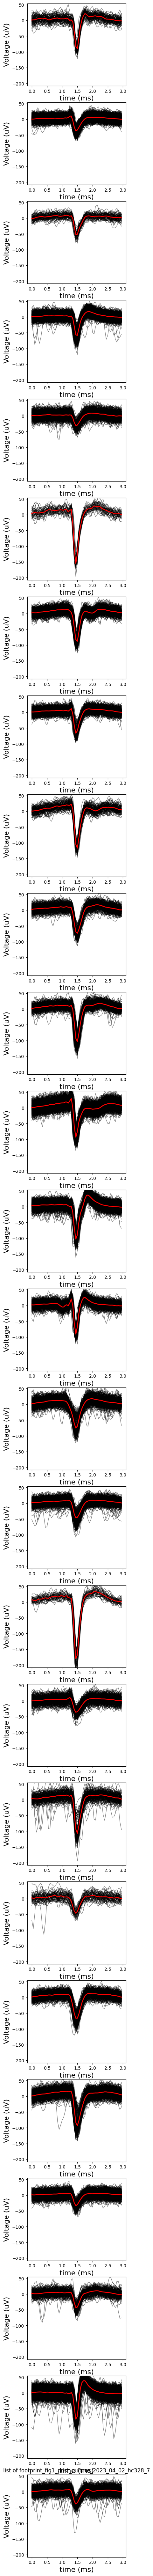

In [14]:
fig, axs = plt.subplots(len(best_units), 1, figsize=(4, 4*len(best_units)), facecolor='white')
plt.title("list of footprint_{}".format(name))
ylim_min, ylim_max = float('inf'), -float('inf')
y_margin = 3

raw_spikes = single_unit.load_spikes_maxwell(rec, near_channels, cluster_spike_times, rec_period=rec_period)

for k in box_units.keys():
    ch = box_units[k]['channel']
    waveforms = box_units[k]['waveforms']
    ylim_min = min(ylim_min, min(waveforms[ch]['mean']-waveforms[ch]['std']))
    ylim_max = max(ylim_max, max(waveforms[ch]['mean']+waveforms[ch]['std']))

min_x, max_x, min_y, max_y = 4000, 0, 3000, 0

for i in range(len(best_units)):
    key = list(best_units.keys())[i]
    mean_waveform = np.mean(best_units[key]["raw_spikes"], axis=0)
    xx = np.arange(0, mean_waveform.shape[0]/fs*1000, (mean_waveform.shape[0]/fs*1000)/mean_waveform.shape[0])
    for spike in best_units[key]["raw_spikes"]:
        axs[i].plot(xx, spike, color='k', linewidth=1, alpha=0.5)
    axs[i].plot(xx, mean_waveform, color='r', linewidth=2)
    axs[i].set_ylim([ylim_min - y_margin, ylim_max + y_margin])
    axs[i].set_ylabel("Voltage (uV)", fontsize=16)
    axs[i].set_xlabel("time (ms)", fontsize=16)

#### Raster of the selected units

In [15]:
# for k in box_units.keys():
#     spike_times_box = [spike_data.train[k] for k in box_units.keys()]
# rec_length = np.sort(np.hstack(spike_data.train))[-1]

In [23]:
from matplotlib.ticker import MaxNLocator
def plot_raster_simple(axs, spike_times):
    bins, rate = analysis.moving_fr_rate(spike_times, bin_size=100)
    for j in range(len(spike_times)):
        yy = [j+1] * len(spike_times[j])
        axs.scatter(np.asarray(spike_times[j])/1000.0, yy, s=10, marker="|", linewidth=0.5, color='k', alpha=1)
    axs.set_ylabel("Unit", fontsize=16)
    axs.set_xlabel("Time (s)", fontsize=16)
    axs.yaxis.set_major_locator(MaxNLocator(integer=True))
    axs.spines['top'].set_visible(False)
    axs.yaxis.set_tick_params(labelsize=16)
    axs.xaxis.set_tick_params(labelsize=16)
    axs.set_xlim(0, 60)

    axs1 = fig.add_subplot(111, facecolor="None")
    axs1.yaxis.set_label_position("right") 
    axs1.plot(bins[:-1]/1000, rate, color='r', linewidth=5, alpha=0.7)
    axs1.set_ylabel("Average Firing Rate (Hz)", fontsize=16, color='r')
    axs1.set_xlabel("Time (s)", fontsize=16)
    axs1.yaxis.set_tick_params(labelsize=16)
    axs1.spines['top'].set_visible(False)
    axs1.get_xaxis().set_visible(False)
    # axs1.yaxis.set_major_locator(MaxNLocator(integer=True))
    axs1.tick_params(left=False, right=True, labelleft=False, labelright=True,
                    bottom=False, labelbottom=True)
    axs1.spines['right'].set_color('r')
    axs1.spines['right'].set_linewidth(3)
    axs1.tick_params(axis='y', colors='r')
    axs1.set_xlim(0, 60)
    axs1.set_ylim(0, 30)
    return axs

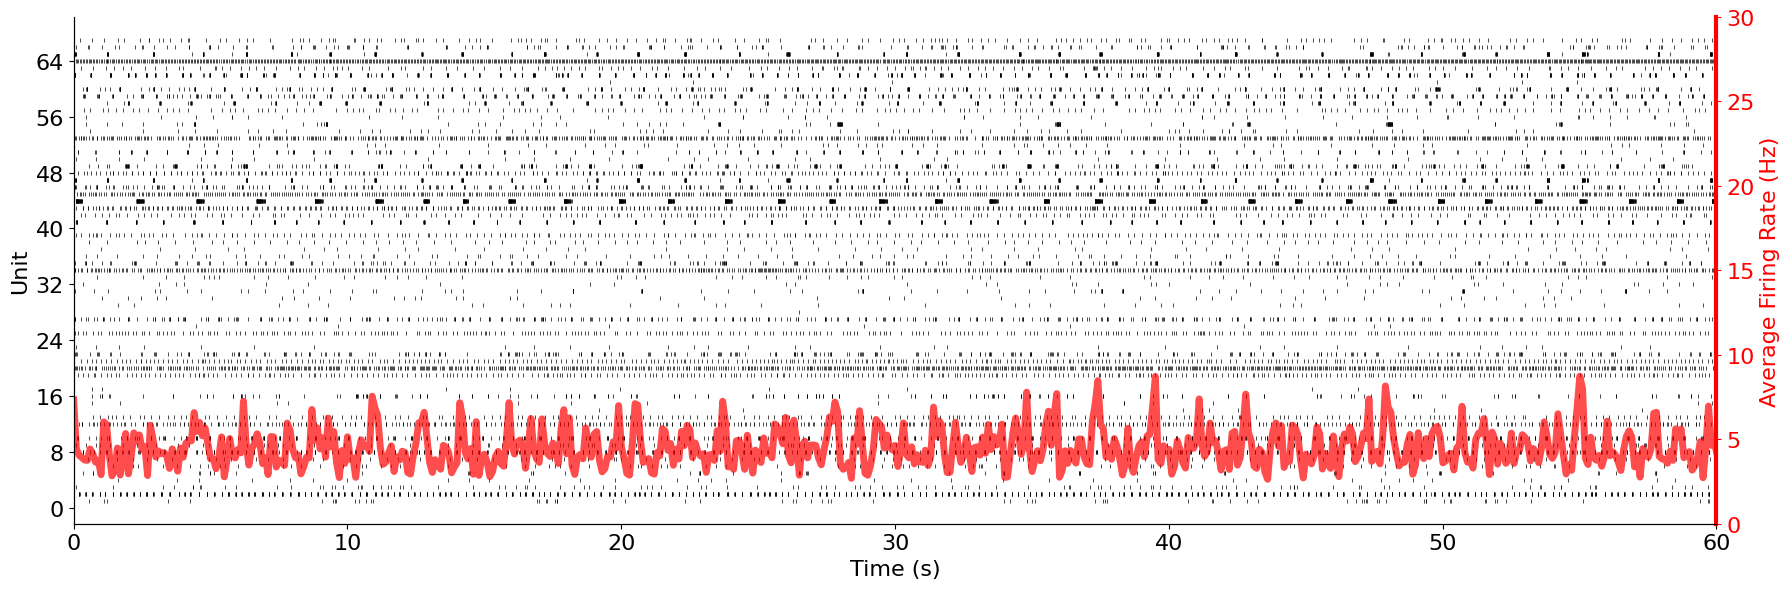

In [24]:
# bins, rate = analysis.moving_fr_rate(spike_times_box)
fig, axs = plt.subplots(1, 1, figsize=(18, 6), tight_layout=True)
axs = plot_raster_simple(axs, spike_data.train)
plt.savefig(figure_path + '{}_raster_box_trans.png'.format(name), transparent=True, dpi=300)
plt.savefig(figure_path + '{}_raster_box.svg'.format(name), dpi=300)